In [366]:
%matplotlib inline
#import ipywidgets as widgets
#from ipywidgets import interact
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.spatial.distance import cdist
#from numpy.linalg import inv
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel
import astropy
from astropy.io import fits
import lightkurve
import theano
import theano.tensor as tt
import pymc3 as pm
from pymc3.step_methods.hmc import quadpotential
from scipy.signal import savgol_filter
#import exoplanet as xo

### 1) Load light curve data

In [367]:
#filename = '/Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits'
filename = '/Users/chrislam/Desktop/epic-246301900/EPIC_246301900_mast.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chrislam/Desktop/epic-246301900/EPIC_246301900_mast.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      50   ()      
  1  K2SC          1 BinTableHDU    109   3526R x 10C   [D, J, J, D, D, D, D, B, D, D]   


In [368]:
data = fits.getdata(filename,header=True,ext=1)
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(df.head())

          time  cadence  quality         x         y         flux      error  \
0  2905.377230   136855   524288 -0.078130 -0.096713          NaN        NaN   
1  2905.397662   136856        0 -0.095587 -0.096286  612915.2500  22.353420   
2  2905.418095   136857        0 -0.115562 -0.097267  612892.8125  22.366695   
3  2905.438527   136858        0 -0.135376 -0.097348  612824.8125  22.378389   
4  2905.458959   136859        0 -0.154696 -0.097495  612975.3750  22.391329   

   mflags         trtime         trposi  
0      33  612997.231238  622581.017209  
1       0  613035.154614  622561.043832  
2       0  613074.991818  622542.655621  
3       0  613117.022632  622531.232874  
4       0  613161.577916  622526.388710  


3248


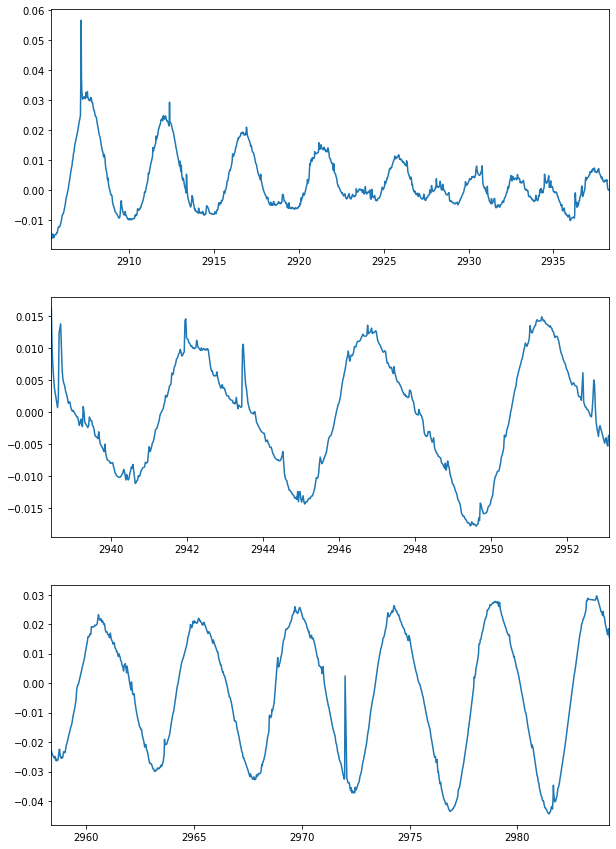

In [369]:
# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder())
df = df.dropna(subset=['time','flux','error']) # toss NaNs since they'll create matrices of NaNs
detrended_k2sc = df.flux - df.trposi + np.nanmedian(df.trposi) - df.trtime + np.nanmedian(df.trtime)
corrected_k2sc = df.flux - df.trposi + np.nanmedian(df.trposi)
df['detrended'] = detrended_k2sc
df['corrected'] = corrected_k2sc
df['detrended_norm'] = detrended_k2sc/np.nanmedian(detrended_k2sc) - 1
df['corrected_norm'] = corrected_k2sc/np.nanmedian(corrected_k2sc) - 1
print(len(df))

pre = df.loc[:1585] # next record is the beginning of the flare, so stop here
post = df.loc[1588:2294] # start from after the flare until beginning of the gap in time series data
postgap = df.loc[2295:] # start from end of the gap in data until end of time series data
df_sans_superflare = pd.concat([pre, post, postgap])

plt.figure(figsize=(10,15))
plt.subplot(311)
xobs = np.array(pre["time"])
yobs = np.array(pre["flux"])
plt.xlim(min(pre.time),max(pre.time))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(312)
xobs = np.array(post["time"])
yobs = np.array(post["flux"])
plt.xlim(min(post.time),max(post.time))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(313)
xobs = np.array(postgap["time"])
yobs = np.array(postgap["flux"])
plt.xlim(min(postgap.time),max(postgap.time))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)
plt.show()

### 2) Load identified flares

In [370]:
tpeaks = flares_pre.fixed_tpeaks
npeaks = len(flares_pre)
print(tpeaks, npeaks)

0     2907.154837
1     2907.154837
2     2907.154837
3     2907.154837
4     2909.524974
5     2909.524974
6     2909.524974
7     2909.524974
8     2912.365041
9     2913.693127
10    2913.693127
11    2913.693127
12    2914.551273
13    2914.551273
14    2916.900956
15    2919.066745
16    2920.783027
17    2920.783027
18    2928.097624
19    2931.101089
20    2934.472318
21    2934.472318
22    2936.290736
23    2936.290736
24    2936.290736
Name: fixed_tpeaks, dtype: float64 25


In [411]:
path = '/Users/chrislam/Desktop/epic-246301900/'
identified_flares = pd.read_csv(path+'injection-recovery/identified_flares_k2sc.csv') # identified_flares.csv
print(identified_flares)

flares_pre = identified_flares.loc[identified_flares.tpeak <= np.max(pre.time)]
flares_post = identified_flares.loc[(identified_flares.tpeak <= np.max(post.time)) & (identified_flares.tpeak > np.max(pre.time))]
flares_postgap = identified_flares.loc[identified_flares.tpeak > np.max(post.time)]

"""
tpeaks = identified_flares.tpeak
ampls = identified_flares.ampls
fwhms = identified_flares.fwhms
npeaks = len(identified_flares)
"""
tpeaks = flares_pre.fixed_tpeaks
ampls = flares_pre.ampls
fwhms = flares_pre.fixed_fwhms/86400. # convert from seconds to days to be in the same units as tpeaks and time
flares_pre['fwhms_fixed_normed'] = (flares_pre.fixed_fwhms/1800)*2/1440
#fwhms = flares_pre.fixed_fwhms_normed
npeaks = len(flares_pre)

preds_old = pd.read_csv(path+'injection-recovery/preds_k2sc.csv') # preds.csv # preds_k2sc.csv
preds = pd.read_csv(path+'injection-recovery/preds_k2sc_flare_subtracted.csv') # preds.csv # preds_k2sc.csv
print(preds)
preds_pre = preds.loc[:len(pre)-1]
preds_post = preds.loc[len(pre)+1:len(pre)+len(post)]
preds_postgap = preds.loc[len(pre)+len(post):]
preds_pre_old = preds_old.loc[:len(pre)-1]
preds_post_old = preds_old.loc[len(pre)+1:len(pre)+len(post)]
preds_postgap_old = preds_old.loc[len(pre)+len(post):]

"""
x = df_sans_superflare.TIME
norm_flux = df.PDCSAP_FLUX/np.median(df.PDCSAP_FLUX) - 1
print(norm_flux)
y = (norm_flux-preds.flux_norm)/np.std(norm_flux-preds.flux_norm) # subtract out GP-modeled spot modulation flux
print(y)
"""
x = pre.time
norm_flux = pre.flux/np.median(pre.flux) - 1
norm_flux = pre.corrected_norm
#print(len(norm_flux), len(preds_pre), len(np.array(norm_flux)-np.array(preds_pre.flux_norm)),norm_flux-preds_pre.flux_norm)
#y_std = (np.array(norm_flux)-np.array(preds_pre.smoothed))/np.std(np.array(norm_flux)-np.array(preds_pre.smoothed)) # subtract out GP-modeled spot modulation flux
y_std = (np.array(norm_flux)-np.array(preds_pre.gp_flare_subtracted))/np.std(np.array(norm_flux)-np.array(preds_pre.gp_flare_subtracted)) # subtract out GP-modeled spot modulation flux

#y = np.array(norm_flux)-np.array(preds_pre.smoothed) # subtract out GP-modeled spot modulation flux
y = np.array(norm_flux)-np.array(preds_pre.gp_flare_subtracted) # subtract out GP-modeled spot modulation flux
y = y - np.median(y)
print(y)
print(len(x), len(y))

    index        tpeak  tpeaks_norm  std_ampls     ampls  fixed_tpeaks  \
0       0  2907.134405   -14.700728   7.950881  0.009329   2907.154837   
1       1  2907.154837   -14.680295  24.787808  0.029084   2907.154837   
2       2  2907.175269   -14.659863   8.218694  0.009643   2907.154837   
3       3  2907.195702   -14.639431   3.675579  0.004313   2907.154837   
4       4  2909.504541   -12.330591   3.386597  0.003974   2909.524974   
5       5  2909.524974   -12.310159   3.762918  0.004415   2909.524974   
6       6  2912.365041    -9.470091   6.217856  0.007296   2912.365041   
7       9  2934.472318    12.637186   3.718867  0.004363   2934.472318   
8      10  2934.492750    12.657617   2.970396  0.003485   2934.472318   
9      11  2936.270304    14.435171   4.889051  0.005736   2936.290736   
10     12  2936.290736    14.455603   5.051218  0.005927   2936.290736   
11     13  2936.311167    14.476034   2.713242  0.003184   2936.290736   
12      2  2938.640373    -7.089749   

In [406]:
flares_pre

,index,tpeak,tpeaks_norm,std_ampls,ampls,fixed_tpeaks,fixed_fwhms,left_bases,right_bases,fwhms_fixed_normed
0,0,2907.134405,-14.700728,7.950881,0.009329,2907.154837,2692.811752,2907.073108,2907.297863,0.002078
1,1,2907.154837,-14.680295,24.787808,0.029084,2907.154837,2692.811752,2907.073108,2907.297863,0.002078
2,2,2907.175269,-14.659863,8.218694,0.009643,2907.154837,2692.811752,2907.073108,2907.297863,0.002078
3,3,2907.195702,-14.639431,3.675579,0.004313,2907.154837,2692.811752,2907.073108,2907.297863,0.002078
4,4,2909.504541,-12.330591,3.386597,0.003974,2909.524974,1146.274105,2909.504541,2909.688431,0.000884
5,5,2909.524974,-12.310159,3.762918,0.004415,2909.524974,1146.274105,2909.504541,2909.688431,0.000884
6,6,2912.365041,-9.470091,6.217856,0.007296,2912.365041,1637.353247,2912.344609,2912.405905,0.001263
7,9,2934.472318,12.637186,3.718867,0.004363,2934.472318,4427.983674,2934.370160,2934.656203,0.003417
8,10,2934.492750,12.657617,2.970396,0.003485,2934.472318,4429.745421,2934.370160,2934.676635,0.003418
9,11,2936.270304,14.435171,4.889051,0.005736,2936.290736,5372.381109,2936.229441,2936.454189,0.004145


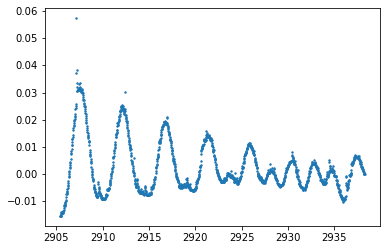

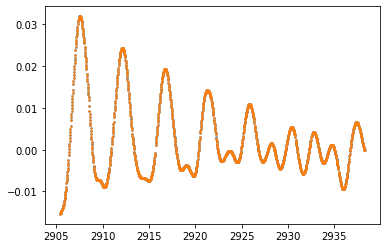

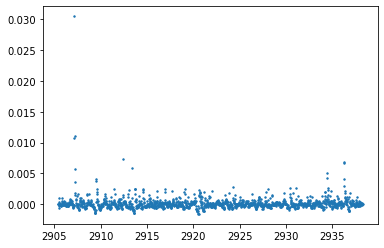

In [407]:
plt.scatter(x, norm_flux, s=2)
plt.show()

plt.scatter(x, np.array(preds_pre.gp_flare_subtracted), s=2) # preds_pre.smoothed
plt.scatter(x, np.array(preds_pre_old.smoothed), s=2) # preds_pre.smoothed
plt.show()

plt.scatter(x, y, s=2)
plt.show()

In [408]:
print(len(preds))
print(len(preds_pre)+len(preds_post)+len(preds_postgap))
print(len(pre)+len(post)+len(postgap))
print(len(preds_pre), len(preds_post), len(preds_postgap))
print(len(pre), len(post), len(postgap))
print(len(preds.loc[:len(pre)-1]), len(preds.loc[len(pre)+1:len(pre)+len(post)]),
     len(preds.loc[len(pre)+len(post):]))

3246
3246
3246
1510 666 1070
1510 666 1070
1510 666 1070


In [409]:
print(len(df))

3248


### 3) Run flare models based on xoflares

Ripped off completely from Tom Barclay's xoflares: https://github.com/mrtommyb/xoflares

In [376]:
# this is the flare model implemented in theano
def get_light_curve(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = time.astype('float64')
    time = tt.as_tensor_variable(time)
    
    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = tt.shape_padright(time) + dt
        
    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)
    
    if texp is not None:
        multiflare_lc = tt.mean(tt.reshape(multiflare_lc, (-1, oversample)),
            axis=1)

    return multiflare_lc

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'

multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))

Maybe oversampling will help? But I don't know what texp should be. So I rip off a random star's texp from the xoflares-real-star.ipynb notebook: https://github.com/mrtommyb/xoflares/blob/master/notebooks/xoflares-real-star.ipynb

In [377]:
"""
# make a light curve
tpf = lightkurve.search_targetpixelfile('LTT 1445').download()
pix_mask = tpf.create_threshold_mask(threshold=2)
corrector = lightkurve.PLDCorrector(tpf)
lc = corrector.correct(aperture_mask=pix_mask,
                       cadence_mask=None,
                       use_gp=False)
lc.flux = lc.flux  * 1e3
texp = tpf.hdu[1].header['FRAMETIM'] * tpf.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
print(texp)
"""

'\n# make a light curve\ntpf = lightkurve.search_targetpixelfile(\'LTT 1445\').download()\npix_mask = tpf.create_threshold_mask(threshold=2)\ncorrector = lightkurve.PLDCorrector(tpf)\nlc = corrector.correct(aperture_mask=pix_mask,\n                       cadence_mask=None,\n                       use_gp=False)\nlc.flux = lc.flux  * 1e3\ntexp = tpf.hdu[1].header[\'FRAMETIM\'] * tpf.hdu[1].header["NUM_FRM"]\ntexp /= 60.0 * 60.0 * 24.0\nprint(texp)\n'

I have entered dependency hell (potentially need to downgrade numpy version), so never mind.

In [378]:
import pymc3_ext as pmx

# make a fine grid that spans the observation window for plotting purposes
t_plot = np.linspace(x.min(), x.max(), 10000)

with pm.Model() as model:
    mean = pm.Normal("mean", mu=0, sd=0.1) # used to be 1.
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=1.) # it'd be much smaller if it were natural log like I used to do
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003, shape=npeaks) # was *0.003
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1., shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1., shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    #flare_lc_pred = get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7) # this one's for plotting only
    pm.Deterministic("flare_lc", flare_lc)
    #pm.Deterministic("flare_lc_pred", flare_lc_pred) # this one's for plotting only
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y) # previously was 2*logs2
    
    map_soln = pmx.optimize(start=model.test_point, vars=[1/fwhm, mean])
    map_soln = pmx.optimize(start=map_soln, vars=[1/ampl, mean])
    map_soln = pmx.optimize(start=map_soln, vars=[1/fwhm, 1/ampl])
    map_soln = pmx.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField()
    pm.fit(method=pm.KLqp(approx), n=500000, 
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=8, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)
    
    

optimizing logp for variables: [mean, logFwhm]


message: Desired error not necessarily achieved due to precision loss.
logp: -2.747097436566733e+20 -> -2.3382881935847014e+20
optimizing logp for variables: [mean, logAmpl]


message: Desired error not necessarily achieved due to precision loss.
logp: -2.3382881935847014e+20 -> -1.7922003376929096e+20
optimizing logp for variables: [logAmpl, logFwhm]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.7922003376929096e+20 -> -9.955571607232928e+19
optimizing logp for variables: [tpeak]


message: Desired error not necessarily achieved due to precision loss.
logp: -9.955571607232928e+19 -> -9.609078449570321e+19


Finished [100%]: Average Loss = -8,833.5


In [379]:
start[0]

{'mean': -0.00018242129799916592,
 'logs2': -3.695805391956248,
 'tpeak': array([2907.15307326, 2907.15423279, 2907.15924729, 2907.14155326,
        2909.52038043, 2909.52193722, 2912.36154708, 2934.47579475,
        2934.47090891, 2936.28945917, 2936.27529477, 2936.28097638]),
 'logFwhm': array([-4.26611895, -4.3714834 , -4.18005813, -3.83708329, -3.36754425,
        -3.3163922 , -4.18320847, -3.23382536, -3.08309637, -3.4091022 ,
        -3.21317061, -4.74268945]),
 'logAmpl': array([-5.9530424 , -4.12797131, -5.83743615, -3.74596831, -5.14070619,
        -6.82152558, -4.88986668, -5.71093545, -7.32550236, -6.86137556,
        -4.72434112, -6.64184621]),
 'fwhm': array([0.01403615, 0.01263249, 0.01529762, 0.02155638, 0.03447419,
        0.0362835 , 0.0152495 , 0.03940647, 0.04581717, 0.03307088,
        0.04022886, 0.00871518]),
 'ampl': array([0.00259792, 0.01611554, 0.00291631, 0.02361275, 0.00585355,
        0.00109006, 0.00752243, 0.00330958, 0.00065853, 0.00104747,
        0.008

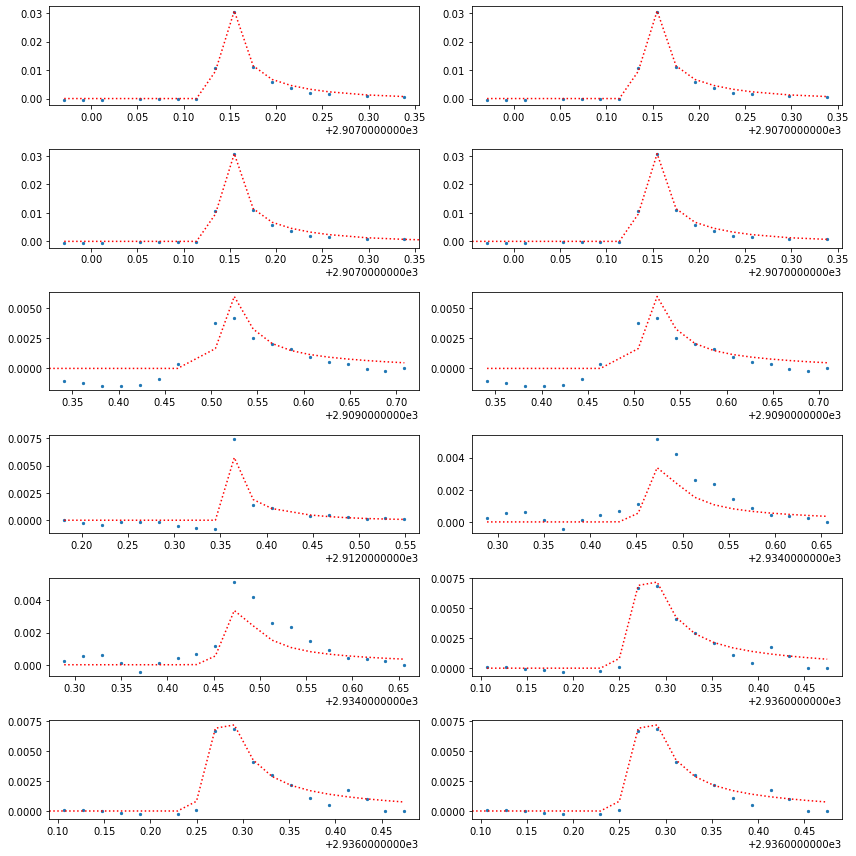

In [380]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
thresh = 0.2
for i in range(npeaks):
    timemask = (x >= tps[i]-thresh) * (x < tps[i]+thresh) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.scatter(x[timemask], y[timemask], s=5)
    ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    #ax.scatter(tpeaks[i], ampls[i])
    ax.set_xlim(tpeaks[i]-thresh, tpeaks[i]+thresh)
    #ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

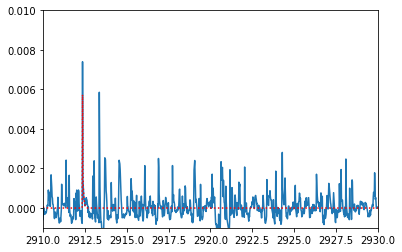

In [381]:
#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#tps = start[0]['tpeak']
plt.plot(x, y)
plt.plot(x, start[0]['flare_lc'], ':r')
plt.xlim(2910, 2930)
plt.ylim(-0.001, 0.01)
plt.show()

In [382]:
with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2000, tune=150, step=step, start=start, cores=8)

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 8 chains for 150 tune and 2_000 draw iterations (1_200 + 16_000 draws total) took 1556 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.829911700283144, but should be close to 0.9. Try to increase the number of tuning steps.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 61 divergences after tuning. Incre

[]

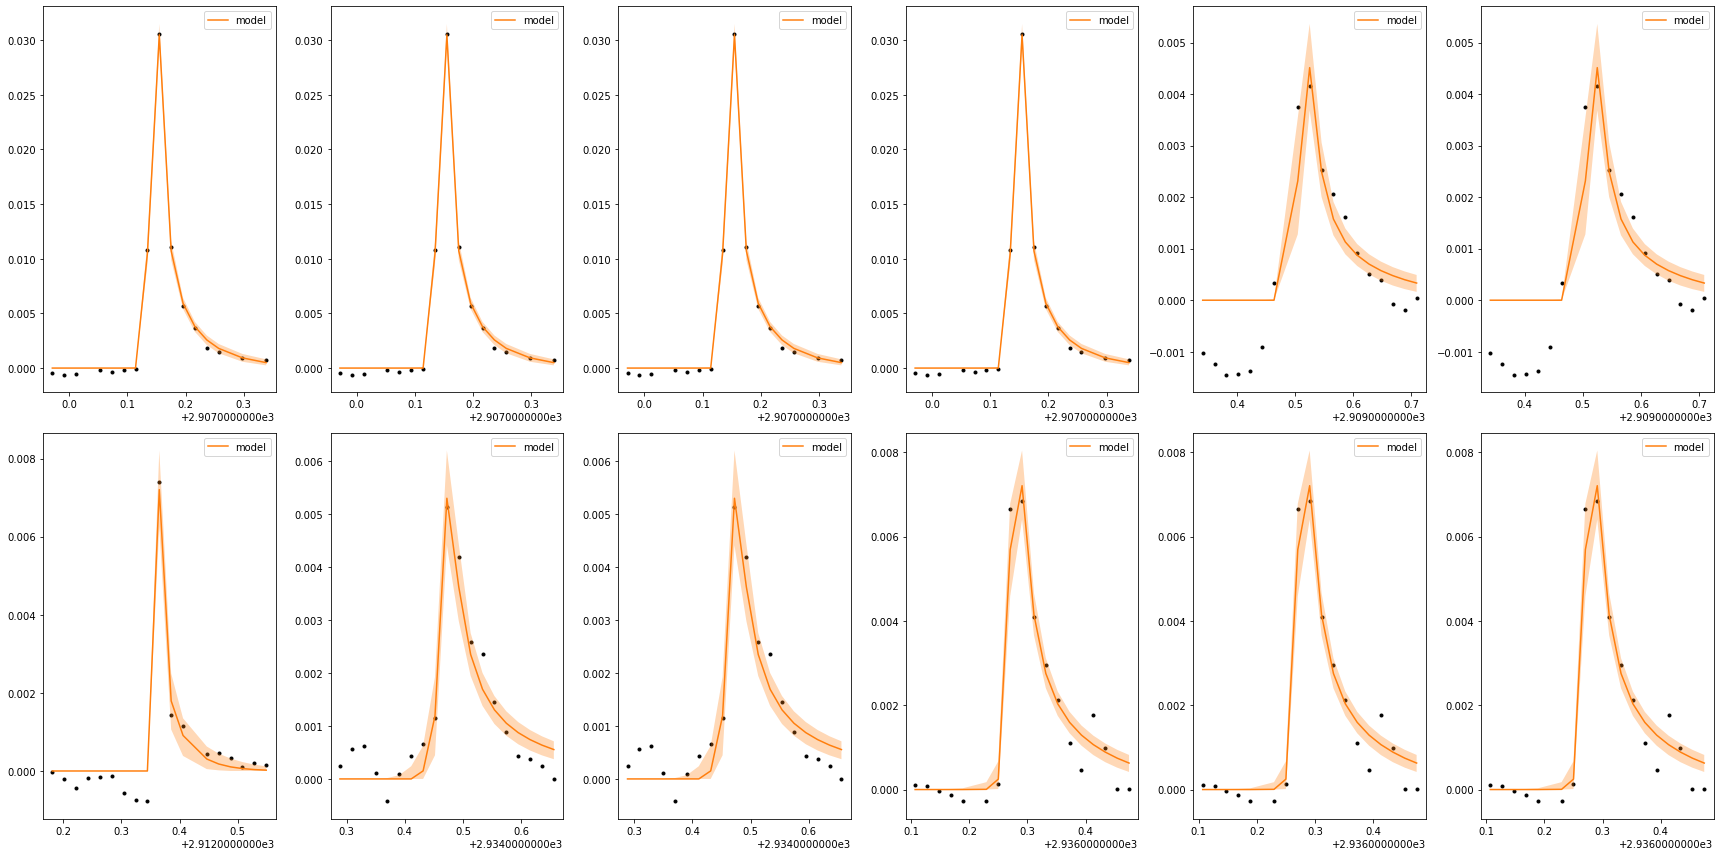

In [383]:
thresh = 0.2
#flc_plot =  np.percentile(trace['flare_lc_pred'], [5, 50, 95], axis=0)
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=6, nrows=np.ceil(npeaks/6).astype(int), figsize=[24,12])
axes = axes.flatten()
for i in range(npeaks):
    #timemask_t_plot = (t_plot >= tpeaks[i]-thresh) * (t_plot < tpeaks[i]+thresh)
    timemask = (x >= tpeaks[i]-thresh) * (x < tpeaks[i]+thresh)
    ax = axes[i]
    #if np.abs(y[timemask]-flc[1][timemask]) <= tol
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], label="model", color="C1")
    art = ax.fill_between(x[timemask], 
                          flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-thresh, tpeaks[i]+thresh)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.tight_layout()
fig.savefig('flare-model-pre.png')
plt.plot()

Got error No model on context stack. trying to find log_likelihood in translation.


<AxesSubplot:title={'center':'acceptance_rate'}>

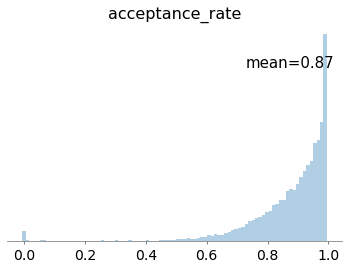

In [384]:
import arviz as az
az.plot_posterior(
    trace, group="sample_stats", var_names="acceptance_rate", hdi_prob="hide", kind="hist"
)

Got error No model on context stack. trying to find log_likelihood in translation.


<AxesSubplot:>

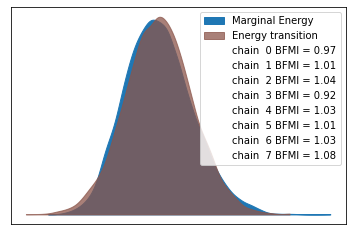

In [385]:
az.plot_energy(trace, figsize=(6, 4))

In [37]:
df.TIME[2]-df.TIME[1]

0.020432287295989227

In [ ]:
list(pm.trace_to_dataframe(trace).columns)

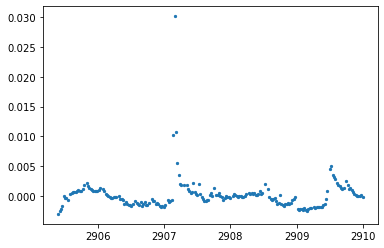

In [26]:
buffer = 0.2
buffer_idx = 8
timemask = (x >= tpeaks[0]-buffer) * (x < tpeaks[0]+buffer)
timemask = (x <= 2910)
plt.scatter(x[timemask], y[timemask], s=5)
plt.show()

tpeaks_test = tpeaks[0:buffer_idx]
npeaks_test = len(tpeaks_test)
x_test = x[timemask]
y_test = y[timemask]
fwhms_test = fwhms[0:buffer_idx]
ampls_test = ampls[0:buffer_idx]


In [ ]:
import corner

# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
#trace._straces[0] = trace._straces[1]
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'ampl', 'fwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'ampl__{}'.format(i),
                               'fwhm__{}'.format(i)]], truths=tpeaks);

In [168]:
samples

,tpeak__0,tpeak__1,tpeak__2,tpeak__3,tpeak__4,tpeak__5,tpeak__6,tpeak__7,tpeak__8,tpeak__9,...,fwhm__27,fwhm__28,fwhm__29,fwhm__30,fwhm__31,fwhm__32,fwhm__33,fwhm__34,fwhm__35,fwhm__36
0,2905.825610,2907.142796,2907.433819,2909.522526,2909.751976,2911.385412,2912.366912,2913.365010,2913.695158,2914.553922,...,0.139767,0.001586,0.170616,0.007796,0.040763,0.103654,0.000796,0.017504,0.004152,0.096335
1,2905.824320,2907.142763,2907.440054,2909.521619,2909.745362,2911.379418,2912.363103,2913.365614,2913.695108,2914.551746,...,0.127520,0.002378,0.143121,0.002630,0.036214,0.083882,0.006519,0.025452,0.001491,0.085729
2,2905.826788,2907.143336,2907.442571,2909.523445,2909.752819,2911.382296,2912.366000,2913.365181,2913.694749,2914.548807,...,0.122684,0.001703,0.205993,0.015943,0.046091,0.121841,0.001423,0.039662,0.009623,0.064769
3,2905.825227,2907.143560,2907.441976,2909.522666,2909.744707,2911.381033,2912.362615,2913.364143,2913.692726,2914.552199,...,0.108315,0.003340,0.198155,0.006169,0.007578,0.093194,0.010049,0.037751,0.003544,0.112858
4,2905.825820,2907.142990,2907.442890,2909.519794,2909.751627,2911.381194,2912.360854,2913.363858,2913.693263,2914.548773,...,0.112817,0.001817,0.164258,0.008421,0.003225,0.093538,0.001937,0.052712,0.005885,0.086856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,2905.829301,2907.143556,2907.445012,2909.525053,2909.746184,2911.381581,2912.362877,2913.366481,2913.697516,2914.555137,...,0.099854,0.007514,0.185490,0.013466,0.012930,0.122656,0.032523,0.024041,0.006995,0.072177
19196,2905.828869,2907.143392,2907.446220,2909.519428,2909.743653,2911.382690,2912.365714,2913.367128,2913.699386,2914.552886,...,0.113246,0.003714,0.168109,0.002641,0.012533,0.106635,0.007222,0.016760,0.004463,0.083827
19197,2905.825391,2907.143537,2907.436163,2909.526806,2909.755721,2911.385133,2912.360920,2913.365627,2913.698829,2914.551858,...,0.092771,0.002228,0.110099,0.023951,0.071514,0.076719,0.001787,0.017709,0.002503,0.052823
19198,2905.826983,2907.143650,2907.441886,2909.528571,2909.753768,2911.383391,2912.360199,2913.365747,2913.698240,2914.551557,...,0.097947,0.002371,0.094093,0.067528,0.042298,0.060226,0.002600,0.019190,0.002091,0.038399


### 3.5) Post and postgap chunks

post

In [386]:
flares_post

,index,tpeak,tpeaks_norm,std_ampls,ampls,fixed_tpeaks,fixed_fwhms,left_bases,right_bases
12,2,2938.640373,-7.089749,6.566433,0.007890,2938.681236,4827.878955,2938.599509,2938.824257
13,3,2938.681236,-7.048886,7.885306,0.009474,2938.681236,5061.870589,2938.599509,2938.865120
14,4,2938.701668,-7.028454,4.636869,0.005571,2938.681236,5201.293301,2938.599509,2938.885552
15,5,2941.950291,-3.779830,3.660942,0.004399,2941.970723,3941.252569,2941.888996,2942.072881
16,6,2941.970723,-3.759399,3.736220,0.004489,2941.970723,3941.252569,2941.888996,2942.072881
17,7,2943.462228,-2.267894,6.762153,0.008125,2943.482659,6441.519970,2943.339638,2943.646112
18,8,2943.482659,-2.247462,7.417570,0.008912,2943.482659,6518.908955,2943.339638,2943.666543
19,9,2943.503091,-2.227031,5.524987,0.006638,2943.482659,6702.525765,2943.339638,2943.686975
20,10,2943.523522,-2.206599,3.810399,0.004578,2943.482659,6702.525765,2943.339638,2943.686975
21,11,2943.543954,-2.186168,2.575377,0.003094,2943.482659,6712.723378,2943.421365,2943.727838


In [387]:
tpeaks_post = flares_post.fixed_tpeaks
ampls_post = flares_post.ampls
fwhms_post = flares_post.fixed_fwhms/86400
flares_post['fwhms_fixed_normed'] = (flares_post.fixed_fwhms/1800)*2/1440
#fwhms = flares_pre.fixed_fwhms_normed
npeaks_post = len(flares_post)

x_post = post.time
norm_flux_post = post.flux/np.median(post.flux) - 1
norm_flux_post = post.corrected_norm

#print(len(norm_flux), len(preds_pre), len(np.array(norm_flux)-np.array(preds_pre.flux_norm)),norm_flux-preds_pre.flux_norm)
y_std_post = (np.array(norm_flux_post)-np.array(preds_post.gp_flare_subtracted))/np.std(np.array(norm_flux_post)-np.array(preds_post.gp_flare_subtracted)) # subtract out GP-modeled spot modulation flux
y_post = np.array(norm_flux_post)-np.array(preds_post.gp_flare_subtracted) # subtract out GP-modeled spot modulation flux
y_post = y_post - np.median(y_post)
#print(y_post)
print(len(x_post), len(y_post))

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'

multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))

666 666


In [388]:
# make a fine grid that spans the observation window for plotting purposes
#t_plot = np.linspace(x.min(), x.max(), 10000)

with pm.Model() as model:
    npeaks = np.shape(tpeaks_post)[0]
    mean = pm.Normal("mean", mu=0, sd=0.1)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y_post)), sd=1.0) # it'd be much smaller if it were natural log like I used to do
    
    tpeak = pm.Normal("tpeak", mu=tpeaks_post, sd=np.ones_like(tpeaks_post) * 0.003, shape=npeaks) 
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms_post), sd=1.0, shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls_post), sd=1.0, shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x_post, tpeak, fwhm, ampl, oversample=15)
    #flare_lc_pred = get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7) # this one's for plotting only
    pm.Deterministic("flare_lc", flare_lc)
    #pm.Deterministic("flare_lc_pred", flare_lc_pred) # this one's for plotting only
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y_post) 
    
    map_soln = pmx.optimize(start=model.test_point, vars=[1/fwhm, mean])
    map_soln = pmx.optimize(start=map_soln, vars=[1/ampl, mean])
    map_soln = pmx.optimize(start=map_soln, vars=[1/fwhm, 1/ampl])
    map_soln = pmx.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField()
    pm.fit(method=pm.KLqp(approx), n=500000, 
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=8, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

optimizing logp for variables: [mean, logFwhm]


message: Desired error not necessarily achieved due to precision loss.
logp: -3.16861970544658e+19 -> -2.562820924810555e+19
optimizing logp for variables: [mean, logAmpl]


message: Desired error not necessarily achieved due to precision loss.
logp: -2.562820924810555e+19 -> -2.1086019236965757e+19
optimizing logp for variables: [logAmpl, logFwhm]


message: Desired error not necessarily achieved due to precision loss.
logp: -2.1086019236965757e+19 -> -1.1570883390956028e+19
optimizing logp for variables: [tpeak]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.1570883390956028e+19 -> -1.0540015742333444e+19


Finished [100%]: Average Loss = -3,490.4


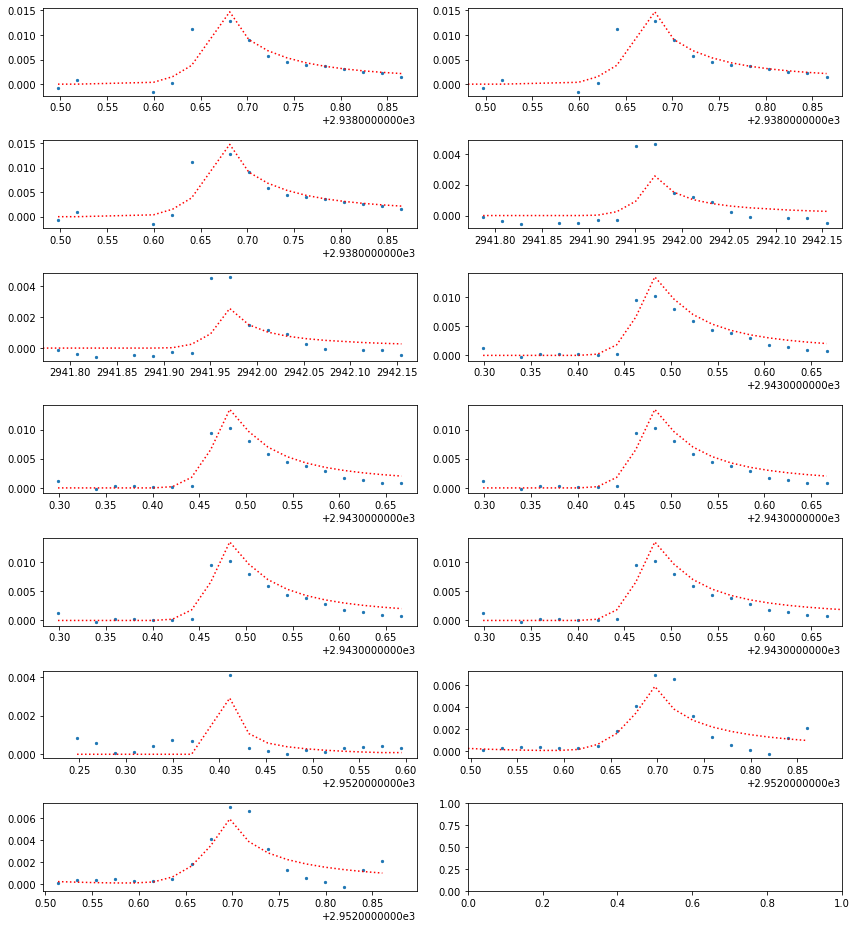

In [389]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x_post >= tps[i]-0.2) * (x_post < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.scatter(x_post[timemask], y_post[timemask], s=5)
    ax.plot(x_post[timemask], start[0]['flare_lc'][timemask], ':r')
    #ax.scatter(tpeaks[i], ampls[i])
    ax.set_xlim(np.array(tpeaks_post)[i]-0.2, np.array(tpeaks_post)[i]+0.2)
    #ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

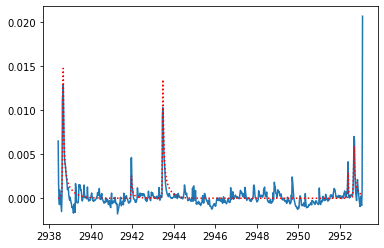

In [390]:
#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#tps = start[0]['tpeak']
plt.plot(x_post, y_post)
plt.plot(x_post, start[0]['flare_lc'], ':r')
plt.show()

In [391]:
with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2000, tune=150, step=step, start=start, cores=8)

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 8 chains for 150 tune and 2_000 draw iterations (1_200 + 16_000 draws total) took 473 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


[]

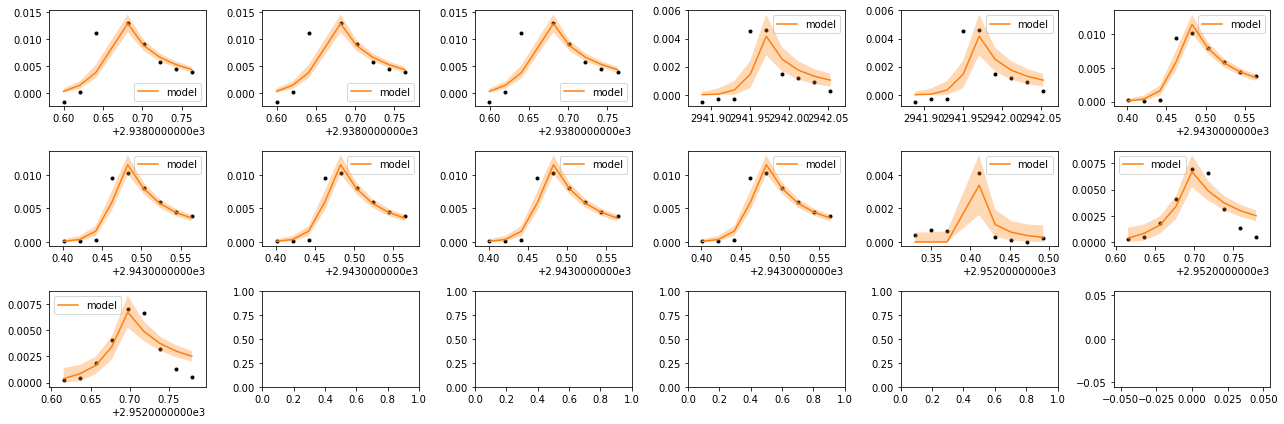

In [392]:
#flc_plot =  np.percentile(trace['flare_lc_pred'], [5, 50, 95], axis=0)
flc_post =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=6, nrows=np.ceil(npeaks_post/6).astype(int), figsize=[18,6])
axes = axes.flatten()
for i in range(npeaks_post):
    #timemask_t_plot = (t_plot >= tpeaks[i]-0.1) * (t_plot < tpeaks[i]+0.1)
    timemask = (x_post >= np.array(tpeaks_post)[i]-0.1) * (x_post < np.array(tpeaks_post)[i]+0.1)
    ax = axes[i]
    ax.plot(x_post[timemask], y_post[timemask], '.k')
    ax.plot(x_post[timemask], flc_post[1][timemask], label="model", color="C1")
    art = ax.fill_between(x_post[timemask], 
                          flc_post[0][timemask],
                          flc_post[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(np.array(np.array(tpeaks_post))[i]-0.1, np.array(tpeaks_post)[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.tight_layout()
fig.savefig('flare-model-post.png')
plt.plot()

postgap

In [393]:
tpeaks_postgap = flares_postgap.fixed_tpeaks
ampls_postgap = flares_postgap.ampls
fwhms_postgap = flares_postgap.fixed_fwhms/86400
flares_postgap['fwhms_fixed_normed'] = (flares_postgap.fixed_fwhms/1800)*2/1440
#fwhms = flares_pre.fixed_fwhms_normed
npeaks_postgap = len(flares_postgap)

x_postgap = postgap.time
norm_flux_postgap = postgap.flux/np.median(postgap.flux) - 1
norm_flux_postgap = postgap.corrected_norm
#print(len(norm_flux), len(preds_pre), len(np.array(norm_flux)-np.array(preds_pre.flux_norm)),norm_flux-preds_pre.flux_norm)
y_std_postgap = (np.array(norm_flux_postgap)-np.array(preds_postgap.gp_flare_subtracted))/np.std(np.array(norm_flux_postgap)-np.array(preds_postgap.gp_flare_subtracted)) # subtract out GP-modeled spot modulation flux
y_postgap = np.array(norm_flux_postgap)-np.array(preds_postgap.gp_flare_subtracted) # subtract out GP-modeled spot modulation flux
y_postgap = y_postgap-np.median(y_postgap)
#print(y_post)
print(len(x_postgap), len(y_postgap))

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'

multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))

1070 1070


In [394]:
# make a fine grid that spans the observation window for plotting purposes
#t_plot = np.linspace(x.min(), x.max(), 10000)
    
with pm.Model() as model:
    mean = pm.Normal("mean", mu=0, sd=0.1)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y_postgap)), sd=1.0) # it'd be much smaller if it were natural log like I used to do
    
    tpeak = pm.Normal("tpeak", mu=tpeaks_postgap, sd=np.ones_like(tpeaks_postgap) * 0.003, shape=npeaks_postgap) 
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms_postgap), sd=1.0, shape=npeaks_postgap)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls_postgap), sd=1.0, shape=npeaks_postgap)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x_postgap, tpeak, fwhm, ampl, oversample=15)
    #flare_lc_pred = get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7) # this one's for plotting only
    pm.Deterministic("flare_lc", flare_lc)
    #pm.Deterministic("flare_lc_pred", flare_lc_pred) # this one's for plotting only
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y_postgap) 
    
    map_soln = pmx.optimize(start=model.test_point, vars=[1/fwhm, mean])
    map_soln = pmx.optimize(start=map_soln, vars=[1/ampl, mean])
    map_soln = pmx.optimize(start=map_soln, vars=[1/fwhm, 1/ampl])
    map_soln = pmx.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField()
    pm.fit(method=pm.KLqp(approx), n=500000, 
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=8, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)
    

optimizing logp for variables: [mean, logFwhm]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.2410089743867037e+20 -> -1.2368353878256822e+20
optimizing logp for variables: [mean, logAmpl]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.2368353878256822e+20 -> -1.2318773886449518e+20
optimizing logp for variables: [logAmpl, logFwhm]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.2318773886449518e+20 -> -1.2245613200333662e+20
optimizing logp for variables: [tpeak]


message: Desired error not necessarily achieved due to precision loss.
logp: -1.2245613200333662e+20 -> -1.222508184743632e+20


Finished [100%]: Average Loss = -5,594.8


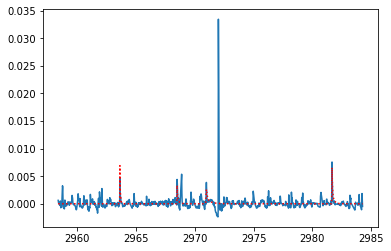

In [395]:
#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#tps = start[0]['tpeak']
plt.plot(x_postgap, y_postgap-np.median(y_postgap))
plt.plot(x_postgap, start[0]['flare_lc'], ':r')
plt.show()

In [396]:
with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2000, tune=150, step=step, start=start, cores=8)

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 8 chains for 150 tune and 2_000 draw iterations (1_200 + 16_000 draws total) took 85 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


[]

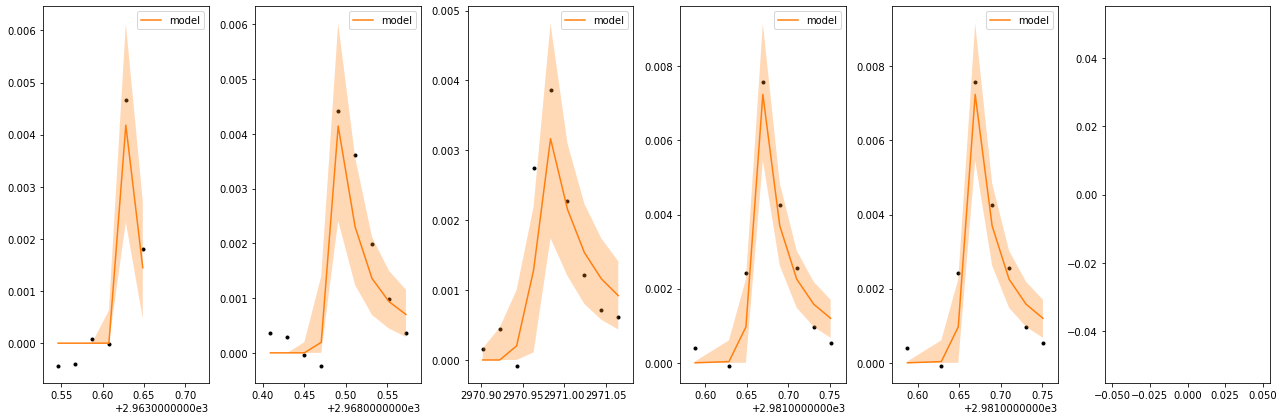

In [397]:
#flc_plot =  np.percentile(trace['flare_lc_pred'], [5, 50, 95], axis=0)
flc_postgap =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=6, nrows=np.ceil(npeaks_postgap/6).astype(int), figsize=[18,6])
axes = axes.flatten()
for i in range(npeaks_postgap):
    #timemask_t_plot = (t_plot >= tpeaks[i]-0.1) * (t_plot < tpeaks[i]+0.1)
    
    timemask = (x_postgap >= np.array(tpeaks_postgap)[i]-0.1) * (x_postgap < np.array(tpeaks_postgap)[i]+0.1)
    ax = axes[i]
    ax.plot(x_postgap[timemask], y_postgap[timemask], '.k')
    ax.plot(x_postgap[timemask], flc_postgap[1][timemask], label="model", color="C1")
    art = ax.fill_between(x_postgap[timemask], 
                          flc_postgap[0][timemask],
                          flc_postgap[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(np.array(np.array(tpeaks_postgap))[i]-0.1, np.array(tpeaks_postgap)[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.tight_layout()
fig.savefig('flare-model-postgap.png')
plt.plot()

### 4) Measuring flare energy

From Doyle et al 2018 "Investigating the rotational phase of stellar flares on M dwarfs using K2 short cadence data"

"To determine the energy of the stellar flares, the quiescent luminosity of the star, L_star, must be calculated in the Kepler bandpass. To construct a template spectral energy distribution for each star we used PanStarrs magnitudes g, r, i, and z (see Table A1). The PanStarrs magnitudes (Chambers et al. 2016) represent the mean quiescent magnitude of the star calculated over an average of multiple measurements. This ensures the effects of flares or rotation has been removed from the magnitudes. We fitted a polynomial to the Panstarrs data and determined the flux in the Keplerbandpass in the same manner as Kowalski et al. (2013). The quiescent luminosity is then computed by multiplying the flux by 4πd2, where the distance (d) to the stars has been determined by inverting the parallax from the Gaia Data 2 release (Gaia Collaboration et al. 2016, 2018; see Table 3)...The energy of the flares, Eflare, can then be determined by the multiplication of the luminosity of the star, L*, in erg s−1 and the equivalent duration, t, in seconds. The equivalent duration (Gershberg 1972) is defined as the area under the flare light curve in units of seconds"

OR, from Davenport 2016 "THE KEPLER CATALOG OF STELLAR FLARES": 

"For this reason it better to not assume a single flare spectrum, and instead I estimate the distance and luminosity for each star to determine it’s quiescent luminosity. The Kepler Input Catalog provides ground-based photometry for all available stars in the Kepler field of view. Using Version 10 of this catalog , I obtained the g, Ks, and Kp (Kepler) photometry for every star in the sample. The g − Ks color is then used to place each star on to a stellar isochrone model, which gives an absolute magnitude and mass for each star. Typical photometric uncertainties from the g − Ks color propagate to mass uncertainties of ∼0.02 M_star. This assumes that all stars in the sample are on the isochrone’s main sequence. A 1- Gyr isochrone from the PARSEC models (Bressan et al. 2012) with Z=0.019 and no dust extinction is used. Note this will yield an incorrect distance for giant and subgiant stars. The star’s absolute g, Ks, and Kp (Kepler) magnitudes are determined by linearly interpolating the observed g − K color to the gridded values from the isochrone. The apparent Ks magnitude for each star is used to determine the distance modulus. The isochronederived absolute Kp magnitude is finally converted from AB magnitudes to a quiescent luminosity, which is denoted LKp, and is used to convert flare ED’s to energies. The resulting flare energy that is calculated does not correct for the spectrum of the flare through the Kepler bandpass, or for the flare energy emitted outside the Kepler bandpass, as discussed more in §6."

Get Kepler magnitude
(https://keplerscience.arc.nasa.gov/CalibrationZeropoint.shtml; Smith et al (ApJ 123, 2121, 2002, Table 7)) 

Convert from AB magnitude to quiescent luminosity
(Davenport 2016; https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions; Oke, J.B. 1974, ApJS, 27, 21)

In [45]:
1./(21.6345*0.001)

46.22246874205551

In [398]:
# flare energy = L_star * ed
# ed = area under the curve
# L_star = 4 * pi * d**2 * luminosity_q
# d = 1/parallax
# luminosity_q = average g, r, i, z magnitudes???
g = 12.076
g = 12.117 # accessed 4/4/22
r = 10.864
r = 10.879 # accessed 4/4/22
i = 10.228
i = 10.245 # accessed 4/4/22
parallax = 21.6345 # in milliarcsecs (mas)
distance = 1./(parallax*0.001) # parsecs
distance = 22.74 # nope, use ExoFOP's value: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
print(distance)

def calculate_energy():
    #l_star = (4*np.pi*distance**2) * ((g+r+i)/3)
    lkp = (4*np.pi*distance**2) * kepmag_zeropoint_luminosity(g, r) * 4000
    print("log LKp: ", np.log10(lkp))
    ed = 0.5*86400*0.05*12000 # from eyeballing one of the flare triangles above
    print("ED: ", ed)
    return np.log10(lkp*ed) # show order of energy in ergs...needs to be ~>27
 
def kepmag_zeropoint_luminosity(g, r): 
    ### kepmag
    # greater error for M dwarfs w/Teff < 3500 K
    # https://keplerscience.arc.nasa.gov/CalibrationZeropoint.shtml
    if (g-r) <= 0.8:
        kp = 0.2*g + 0.8*r
    else:
        kp = 0.1*g + 0.9*r
    #print("Kp: ", kp)
    
    # nope, use ExoFOP's value: 10.807, https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
    kp = 10.807
    
    ### zeropoint, bolometric correction, and magnitude-to-luminosity formula
    # AB mag to f, then multiply by Kepler filter FWHM of 4000 Angstroms
    # per https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions
    # and https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    
    #pre_lkp = 4000 * np.exp(-(kp+48.6)/2.5) # Angstrom * erg/(s*Angstrom*cm^2) # https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/mags.html#conversions
    #pre_lkp = 4000 * np.exp(-(kp+4.81)/2.5) # Angstrom * erg/(s*Angstrom*cm^2) # https://academic.oup.com/mnras/article/433/2/1133/1747991
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    pre_lkp = l_sun * np.power(10, 0.4*(4.81-kp)) # Eqn 3 in https://academic.oup.com/mnras/article/433/2/1133/1747991
    pre_lkp = l_sun * np.power(10, 0.4*(-20.24-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    pre_lkp = l_sun * np.power(10, -0.4*(-20.24+kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf#f12 = 1.74e5 # e-/s, per https://keplergo.arc.nasa.gov/CalibrationSN.shtml
    #pre_lkp = f12 * np.power(10, 0.4*(12-kp))
    print("log pre LKp: ", np.log10(pre_lkp)) # erg/(s*cm^2)
    return pre_lkp
    
print("log flare energy: ", calculate_energy())



22.74
log pre LKp:  39.25217030267259
log LKp:  46.66702107872608
ED:  25920000.0
log flare energy:  54.08065607592464


#### 4.5) the super-flare

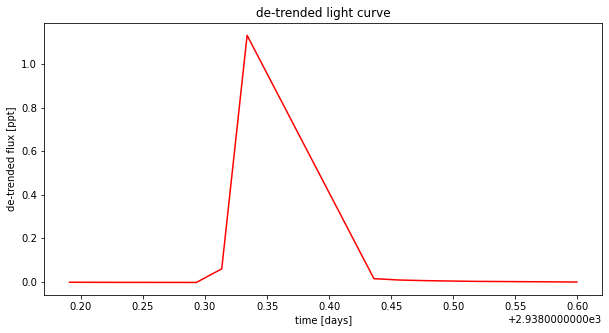

In [399]:
def normalize_flux(flux):
    return flux/np.median(flux) - 1
#superflare = df.loc[1569:1655] # area around the superflare
superflare = df.loc[1579:1600] # area around the superflare

plt.figure(figsize=(10, 5))
#detrended_superflare = superflare.PDCSAP_FLUX-np.ones(len(superflare))*np.median(superflare.PDCSAP_FLUX)
#detrended_superflare = normalize_flux(pd.concat([pre.PDCSAP_FLUX, post.PDCSAP_FLUX, postgap.PDCSAP_FLUX]))
detrended_superflare = normalize_flux(superflare.flux)
plt.plot(superflare.time, detrended_superflare, "r")
#plt.plot(superflare.TIME[mask], superflare.PDCSAP_FLUX[mask], "k")
#plt.plot(pre.TIME, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("de-trended light curve")
#plt.ylim(580000, 680000)
#plt.xlim(superflare.TIME.min(), superflare.TIME.max())
#plt.savefig('superflare.png')
plt.show()

In [400]:
print(detrended_superflare)#[1585:1593])
#print(superflare.iloc[1585:1593].time)

1580   -0.002553
1581   -0.002847
1582   -0.003209
1583   -0.003202
1584   -0.003363
1585   -0.003468
1586    0.059124
1587    1.133086
1592    0.013980
1593    0.007667
1594    0.004890
1595    0.003041
1596    0.001515
1600   -0.001515
Name: flux, dtype: float64


Hold up...so the superflare is just a single data point? Could this be a systematics/cosmic ray type situation? This introduces challenges with calculating the equivalent duration and therefore the flare's energy. 

### 5) Flare frequency distribution

In [401]:
superflare_ed = np.trapz(detrended_superflare, superflare.time*86400)
print(superflare_ed)

6177.3047867753085


The following cell contains equivalent duration calculations done before I saved off left and right bases using peak_prominences(), so I was fudging the bounds of the flare.

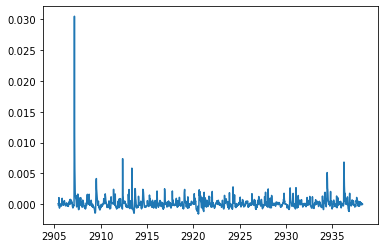

In [402]:
plt.plot(x,y)

In [403]:
tpeaks

0     2907.154837
1     2907.154837
2     2907.154837
3     2907.154837
4     2909.524974
5     2909.524974
6     2912.365041
7     2934.472318
8     2934.472318
9     2936.290736
10    2936.290736
11    2936.290736
Name: fixed_tpeaks, dtype: float64

In [404]:
npeaks+npeaks_post+npeaks_postgap

31

In [412]:
# get equivalent durations
ed_data = []
ed_model = []
ed_minus = []
ed_plus = []
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ed_data.append(np.trapz(y[timemask]*86400, x[timemask]))
    ed_model.append(np.trapz(flc[1][timemask]*86400, x[timemask]))
    ed_minus.append(np.trapz(flc[0][timemask]*86400, x[timemask]))
    ed_plus.append(np.trapz(flc[2][timemask]*86400, x[timemask]))
    
print(ed_data)
print(ed_model)

# and multiply with quiescent luminosity to get flare energies

[116.53382750356721, 116.53382750356721, 116.53382750356721, 116.53382750356721, 19.665914876570856, 19.665914876570856, 16.12304583340518, 37.1270791437609, 37.1270791437609, 46.34635000705863, 46.34635000705863, 46.34635000705863]
[121.81381627802764, 121.81381627802764, 121.81381627802764, 121.81381627802764, 28.89593039343717, 28.89593039343717, 19.79908112417728, 33.89755538415166, 33.89755538415166, 49.407024077220186, 49.407024077220186, 49.407024077220186]


This is EDs done using left and right bases from peak_prominences()

In [413]:
# get equivalent durations
ed_data = []
ed_model = []
ed_minus = []
ed_plus = []
for i in range(npeaks):
    timemask = (x >= flares_pre.left_bases[i]) & (x < flares_pre.right_bases[i])
    ed_data.append(np.trapz(y[timemask]*86400, x[timemask]))
    ed_model.append(np.trapz(flc[1][timemask]*86400, x[timemask]))
    ed_minus.append(np.trapz(flc[0][timemask]*86400, x[timemask]))
    ed_plus.append(np.trapz(flc[2][timemask]*86400, x[timemask]))
    
print(ed_data)
print(ed_model)
print(ed_minus)
print(ed_plus)

# and multiply with quiescent luminosity to get flare energies

[112.79144236688163, 112.79144236688163, 112.79144236688163, 112.79144236688163, 17.49812423947545, 17.49812423947545, 13.645001197695894, 34.75050938256103, 34.97382639403796, 46.84033235693042, 46.84033235693042, 46.84033235693042]
[114.47780039625621, 114.47780039625621, 114.47780039625621, 114.47780039625621, 18.137490451431823, 18.137490451431823, 14.303588440694554, 32.84447916807183, 33.89755538415166, 46.521326795418496, 46.521326795418496, 46.521326795418496]
[106.55181126657935, 106.55181126657935, 106.55181126657935, 106.55181126657935, 14.005701670262898, 14.005701670262898, 11.967672494516739, 25.477087873332586, 26.198992696348306, 39.42954667331252, 39.42954667331252, 39.42954667331252]
[122.49432018957228, 122.49432018957228, 122.49432018957228, 122.49432018957228, 22.410912564896226, 22.410912564896226, 16.689745493354, 41.491322336390084, 42.8293214079953, 53.756720005564205, 53.756720005564205, 53.756720005564205]


Why are my flare energies just a little smaller than I expect? Let's test the formula I've derived from the Hawley et al paper for quiescent luminosity. Test case: GJ 4099, aka KIC 004142913

In [414]:
gj_kep_mag = 10.9
gj_distance = 16.2 # parsecs
gj_lum = 31.64
zeropoint = -20.24
gj_pre_lkp = 3.846e33 * np.power(10, 0.4*(zeropoint-gj_kep_mag)) 
gj_lkp = (4*np.pi*gj_distance**2) * gj_pre_lkp * 4000
np.log10(gj_lkp)

28.24930916433778

Uh oh, the paper reports the log quiescent Kepler luminosity as 31.64. Where am I losing three orders of magnitude??

#### Arjun Savel's recipe (thanks, Arjun!):
1. find Gaia photometric zeropoint
2. cross-match with gaia
3. get apparent mag in gaia
4. apply the Gaia zeropoint
5. convert to absolute mag
6. get the bolometric correction
7. apply the bolometric correction
8. bolometric mag --> luminosity

In [415]:
zp_gaia_rp = 24.7619 # from Table 1 from Gaia DR 2 paper (Evans et al 2018) 
zp_gaia_bp = 25.3514 # https://www.aanda.org/articles/aa/full_html/2018/08/aa32756-18/aa32756-18.html#T2
bolo_mag_sun = 4.75
bolo_lum_sun = 3.86e33

In [416]:
with fits.open('/Users/chrislam/Desktop/sculpting/crossmatch_fun/kepler_dr2_1arcsec.fits') as data:
    data = pd.DataFrame(data[1].data)
rp_Mag = zp_gaia_rp - list(data.loc[data.kepid==4142913].phot_rp_mean_mag)[0]
rp_Mag = rp_Mag - 5*np.log10(distance) + 5
bp_Mag = zp_gaia_bp - list(data.loc[data.kepid==4142913].phot_bp_mean_mag)[0]
bp_Mag = bp_Mag - 5*np.log10(distance) + 5
bp_rp = bp_Mag - rp_Mag # THIS IS THE ABSOLUTE BP-RP MAGNITUDE
print("absolute Bp-Rp magnitude: ", bp_rp)

bc_a = 0.7384 # from Mann et al 2015 Table 3 for Gaia bp-rp 
bc_b = -0.7398 # "How to Constrain Your M Dwarf": https://arxiv.org/pdf/1501.01635.pdf
bc_c = 0.01340
bc_error = 0.045
bc = bc_a + bc_b * bp_rp + bc_c * bp_rp**2
print("bolometric correction: ", bc)

# following Eqn 3 in Farmer et al 2013: https://arxiv.org/pdf/1302.2867.pdf...
# I bring M_bol_sun and BC_x on the RHS over to the left to make a single Mag term on the LHS
# M_x is the absolute Bp-Rp magnitude
Mag = bp_rp + bolo_mag_sun + bc
luminosity = np.power(10, -0.4*Mag) * bolo_lum_sun
print("luminosity: ", luminosity, "log luminosity: ", np.log10(luminosity))

absolute Bp-Rp magnitude:  -1.6073536376953115
bolometric correction:  1.9621402697695969
luminosity:  3.5048759539587812e+31 log luminosity:  31.544672651842042


Much better! Now, let's do this for our actual star. 

First, let's show the old way.

In [417]:
kep_mag = 10.807
distance = 22.74 # parsecs
zeropoint = -20.24
pre_lkp = 3.846e33 * np.power(10, 0.4*(zeropoint-kep_mag)) 
lkp = (4*np.pi*distance**2) * pre_lkp * 4000
print("old way log quiescent luminosity for EPIC 246301900: ", np.log10(lkp))

old way log quiescent luminosity for EPIC 246301900:  28.581060055955952


And, now, the new way.

In [418]:
with fits.open('k2_dr2_1arcsec.fits') as kep_data:
    kep_data = pd.DataFrame(kep_data[1].data)
    
#print(kep_data.head())
#print(list(kep_data.columns))
#print(kep_data.loc[kep_data.epic_number==246301900])


In [419]:
print(kep_data.loc[kep_data.epic_number==246301900].phot_rp_mean_mag)
print(kep_data.loc[kep_data.epic_number==246301900].phot_bp_mean_mag)
rp_Mag = zp_gaia_rp - list(kep_data.loc[kep_data.epic_number==246301900].phot_rp_mean_mag)[0]
rp_Mag = rp_Mag - 5*np.log10(distance) + 5
bp_Mag = zp_gaia_bp - list(kep_data.loc[kep_data.epic_number==246301900].phot_bp_mean_mag)[0]
bp_Mag = bp_Mag - 5*np.log10(distance) + 5
bp_rp = bp_Mag - rp_Mag # THIS IS THE ABSOLUTE BP-RP MAGNITUDE
print(rp_mag)
print(bp_mag)
print("absolute Bp-Rp magnitude: ", bp_rp)

343801    9.857057
Name: phot_rp_mean_mag, dtype: float32
343801    11.546909
Name: phot_bp_mean_mag, dtype: float32
14.904843382263184
13.804490667724611
absolute Bp-Rp magnitude:  -1.1003527145385732


In [420]:
bc_a = 0.7384 # from Mann et al 2015 Table 3 for Gaia bp-rp 
bc_b = -0.7398 # "How to Constrain Your M Dwarf": https://arxiv.org/pdf/1501.01635.pdf
bc_c = 0.01340
bc_error = 0.045
bc = bc_a + bc_b * bp_rp + bc_c * bp_rp**2
print("bolometric correction: ", bc)

bolometric correction:  1.5686653379072948


In [421]:
# following Eqn 3 in Farmer et al 2013: https://arxiv.org/pdf/1302.2867.pdf...
# I bring M_bol_sun and BC_x on the RHS over to the left to make a single Mag term on the LHS
# M_x is the absolute Bp-Rp magnitude
Mag = bp_rp + bolo_mag_sun + bc
luminosity = np.power(10, -0.4*Mag) * bolo_lum_sun
log_luminosity = np.log10(luminosity)
print("luminosity: ", luminosity, "log luminosity: ", log_luminosity)

luminosity:  3.156910396230238e+31 log luminosity:  31.499262255324265


Great! This is three orders of magnitude higher than the old quiescent luminosity and should therefore put the FFDs in a more reasonable place. The issue of a little too many flares remains, though, right?

In [422]:
def calculate_energy(kp, zeropoint, ed_model):
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    l_sun = 3.846e33 # erg/s
    pre_lkp = l_sun * np.power(10, 0.4*(zeropoint-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    print("log pre LKp: ", np.log10(pre_lkp)) # erg/(s*cm^2)
    lkp = (4*np.pi*distance**2) * pre_lkp * 4000
    print("log LKp: ", np.log10(lkp))
    print("ED: ", ed_model)
    try:
        return np.log10(lkp*ed_model)
    except:
        return np.log10([lkp*ed for ed in ed_model]) # show order of energy in ergs
    
def calculate_energy2(luminosity, ed_model):
    """
    luminosity: quiescent luminosity of the star calculated via the recipe described above [erg/s]
    ed_model: equivalent durations [s]
    """
    
    try: # if in list 
        return np.log10([luminosity*ed for ed in ed_model]) # show order of energy in ergs
    except: # superflare is a single value, so it's not in a list
        return np.log10(luminosity*ed_model)
    

### use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
#flare_energies = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model)
#flare_energies_minus = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_minus)
#flare_energies_plus = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_plus)
flare_energies = calculate_energy2(luminosity, ed_model=ed_model)
flare_energies_minus = calculate_energy2(luminosity, ed_model=ed_minus)
flare_energies_plus = calculate_energy2(luminosity, ed_model=ed_plus)

### add the superflare
#flare_energies = np.append(flare_energies, calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=superflare_ed))
#flare_energies_minus = np.append(flare_energies_minus, calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=superflare_ed))
#flare_energies_plus = np.append(flare_energies_plus, calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=superflare_ed))
flare_energies = np.append(flare_energies, calculate_energy2(luminosity, ed_model=superflare_ed))
flare_energies_minus = np.append(flare_energies_minus, calculate_energy2(luminosity, ed_model=superflare_ed))
flare_energies_plus = np.append(flare_energies_plus, calculate_energy2(luminosity, ed_model=superflare_ed))

print("log flare energy: ", np.sort(flare_energies))

log flare energy:  [32.65470726 32.75783945 32.75783945 33.01572463 33.02943063 33.16691435
 33.16691435 33.16691435 33.55798353 33.55798353 33.55798353 33.55798353
 35.29006129]


In [423]:
np.log10(luminosity*superflare_ed)

35.2900612851789

Do the same for post and postgap chunks

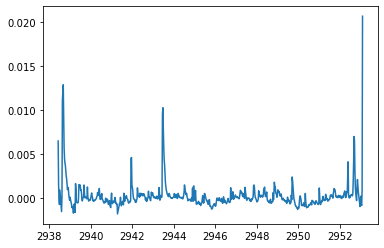

In [424]:
plt.plot(x_post, y_post)

In [425]:
# get equivalent durations
ed_data_post = []
ed_model_post = []
ed_minus_post = []
ed_plus_post = []
for i in range(npeaks_post):
    timemask = (x_post >= flares_post.reset_index().left_bases[i]) & (x_post < flares_post.reset_index().right_bases[i])
    ed_data_post.append(np.trapz(y_post[timemask]*86400, x_post[timemask]))
    ed_model_post.append(np.trapz(flc_post[1][timemask]*86400, x_post[timemask]))
    ed_minus_post.append(np.trapz(flc_post[0][timemask]*86400, x_post[timemask]))
    ed_plus_post.append(np.trapz(flc_post[2][timemask]*86400, x_post[timemask]))
    
print(ed_data_post)
print(ed_model_post)
print(ed_minus_post)
print(ed_plus_post)

### Then multiply with quiescent luminosity to get flare energies
### use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
#flare_energies_post = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model_post)
#flare_energies_minus_post = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_minus_post)
#flare_energies_plus_post = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_plus_post)
flare_energies_post = calculate_energy2(luminosity, ed_model=ed_model_post)
flare_energies_minus_post = calculate_energy2(luminosity, ed_model=ed_minus_post)
flare_energies_plus_post = calculate_energy2(luminosity, ed_model=ed_plus_post)

### append
flare_energies = np.append(flare_energies, flare_energies_post)
flare_energies_minus = np.append(flare_energies_minus, flare_energies_minus_post)
flare_energies_plus = np.append(flare_energies_plus, flare_energies_plus_post)
print("log flare energy: ", np.sort(flare_energies))

[113.01918094536884, 122.11348578324787, 125.41495301087824, 21.86991971381099, 21.86991971381099, 84.98054165173806, 86.99999199515901, 89.54546205530934, 89.54546205530934, 89.19030395603446, 18.79034734509318, 44.51017176823297, 44.51017176823297]
[100.47835666786146, 110.26832399446522, 114.34487204816223, 21.282585150648114, 21.282585150648114, 84.06466503452036, 87.67866890022071, 93.72641753092498, 93.72641753092498, 95.75102215968555, 14.325166145262418, 49.45194637024999, 49.45194637024999]
[85.9081460439509, 94.35463559188686, 97.84310160027171, 12.405086952385124, 12.405086952385124, 71.48457664719638, 74.5481016119958, 79.59378601736944, 79.59378601736944, 81.61748237815337, 5.0574018238584175, 36.46376326755754, 36.46376326755754]
[116.38679663177918, 127.50291228619689, 132.15573854307019, 31.07568033863126, 31.07568033863126, 99.08451504871604, 103.25238196021559, 110.28839668832643, 110.28839668832643, 111.18279892085283, 36.44179678876881, 62.990186776498014, 62.990186

In [426]:
# get equivalent durations
ed_data_postgap = []
ed_model_postgap = []
ed_minus_postgap = []
ed_plus_postgap = []
for i in range(npeaks_postgap):
    timemask = (x_postgap >= flares_postgap.reset_index().left_bases[i]) & (x_postgap < flares_postgap.reset_index().right_bases[i])
    ed_data_postgap.append(np.trapz(y_postgap[timemask]*86400, x_postgap[timemask]))
    ed_model_postgap.append(np.trapz(flc_postgap[1][timemask]*86400, x_postgap[timemask]))
    ed_minus_postgap.append(np.trapz(flc_postgap[0][timemask]*86400, x_postgap[timemask]))
    ed_plus_postgap.append(np.trapz(flc_postgap[2][timemask]*86400, x_postgap[timemask]))
    
print(ed_data_postgap)
print(ed_model_postgap)
print(ed_minus_postgap)
print(ed_plus_postgap)

### Then multiply with quiescent luminosity to get flare energies
### use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
#flare_energies_postgap = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model_postgap)
#flare_energies_minus_postgap = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_minus_postgap)
#flare_energies_plus_postgap = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_plus_postgap)
flare_energies_postgap = calculate_energy2(luminosity, ed_model=ed_model_postgap)
flare_energies_minus_postgap = calculate_energy2(luminosity, ed_model=ed_minus_postgap)
flare_energies_plus_postgap = calculate_energy2(luminosity, ed_model=ed_plus_postgap)

### append
flare_energies = np.append(flare_energies, flare_energies_postgap)
flare_energies_minus = np.append(flare_energies_minus, flare_energies_minus_postgap)
flare_energies_plus = np.append(flare_energies_plus, flare_energies_plus_postgap)
print("log flare energy: ", np.sort(flare_energies))

[1.4553076062614898, 19.07798588457588, 20.200051156754377, 33.61736033955608, 33.61736033955608]
[3.6907141730294315, 19.91159112688655, 20.326323190236938, 33.54006034128319, 33.54006034128319]
[2.0503831348187562, 9.74720397685139, 9.45731883801053, 21.489546164385292, 21.489546164385292]
[6.518824708623337, 32.2445686002373, 33.33378273484651, 46.78742955315854, 46.78742955315854]
log flare energy:  [32.06637267 32.65470726 32.65536192 32.75783945 32.75783945 32.79836822
 32.80732108 32.82728663 32.82728663 33.01572463 33.02482609 33.02482609
 33.02943063 33.16691435 33.16691435 33.16691435 33.19344564 33.19344564
 33.42387574 33.4421562  33.47112427 33.47112427 33.48040567 33.50133478
 33.54171303 33.55747895 33.55798353 33.55798353 33.55798353 33.55798353
 35.29006129]


In [427]:
flares_postgap

,index,tpeak,tpeaks_norm,std_ampls,ampls,fixed_tpeaks,fixed_fwhms,left_bases,right_bases
25,2,2963.628134,-7.692522,3.946993,0.005057,2963.628134,1444.303532,2963.505545,2963.648566
26,3,2968.490843,-2.829814,2.932769,0.003757,2968.490843,4458.776215,2968.470411,2968.674727
27,5,2970.983495,-0.337162,2.850288,0.003652,2970.983495,4585.136253,2970.840474,2971.106084
28,7,2981.669248,10.348591,5.287361,0.006774,2981.669248,3472.846028,2981.628384,2981.832702
29,8,2981.689680,10.369023,2.688765,0.003445,2981.669248,3472.846028,2981.628384,2981.832702


In [428]:
np.trapz(y_postgap[timemask]*86400, x_postgap[timemask])

33.61736033955608

In [429]:
np.trapz(flc_postgap[0][timemask]*86400, x_postgap[timemask])

21.489546164385292

In [430]:
x_postgap[timemask]

3419    2981.628384
3420    2981.648816
3421    2981.669248
3422    2981.689680
3423    2981.710111
3424    2981.730543
3425    2981.750975
3426    2981.771406
3427    2981.791838
3428    2981.812270
Name: time, dtype: float64

In [431]:
y_postgap[timemask]

array([-7.79656636e-05,  2.41590859e-03,  7.57527290e-03,  4.24779387e-03,
        2.56992227e-03,  9.72135374e-04,  5.32408147e-04,  3.30488482e-04,
        3.06473566e-04,  2.63967705e-04])

Plot FFD

(array([ 1.,  2., 10.,  5., 12.,  0.,  0.,  0.,  0.,  1.]),
 array([32.06637267, 32.38874153, 32.71111039, 33.03347925, 33.35584811,
        33.67821698, 34.00058584, 34.3229547 , 34.64532356, 34.96769242,
        35.29006129]),
 <BarContainer object of 10 artists>)

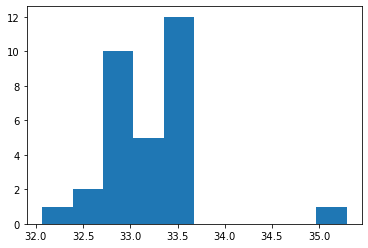

In [433]:
plt.hist(flare_energies, bins=10)

In [434]:
flare_energies[flare_energies<32]

array([], dtype=float64)

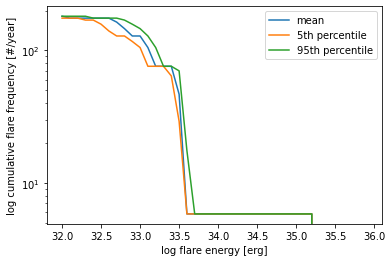

In [436]:
hist, edges = np.histogram(flare_energies, bins=np.linspace(32.0, 36.0, 41))
hist_minus, edges_minus = np.histogram(flare_energies_minus, bins=np.linspace(32.0, 36.0, 41))
hist_plus, edges_plus = np.histogram(flare_energies_plus, bins=np.linspace(32.0, 36.0, 41))

# completeness factor of fn/fp from injection recovery
fn = 14 # 9, 14, 19
fp = 0
samples = 50
completeness_factor = (samples+fn-fp)/samples
#completeness_factor = 1

#plt.scatter(edges[:-1], np.log10(hist/80)) # divided by time series length of 80 days
#plt.scatter(edges[:-1], np.log10(np.cumsum(hist[::-1])[::-1]/80)) # cumulative sum; invert order b/c they count from highest bin
#plt.scatter(edges_minus[:-1], np.log10(np.cumsum(hist_minus[::-1])[::-1]/80), marker='v') # cumulative sum; invert order b/c they count from highest bin
#plt.scatter(edges_plus[:-1], np.log10(np.cumsum(hist_plus[::-1])[::-1]/80), marker='^') # cumulative sum; invert order b/c they count from highest bin
#plt.plot(edges[:-1], np.log10(np.cumsum(hist[::-1])[::-1]/80), label='mean') # cumulative sum; invert order b/c they count from highest bin
#plt.plot(edges_minus[:-1], np.log10(np.cumsum(hist_minus[::-1])[::-1]/80), label='5th percentile') # cumulative sum; invert order b/c they count from highest bin
#plt.plot(edges_plus[:-1], np.log10(np.cumsum(hist_plus[::-1])[::-1]/80), label='95th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges[:-1], np.cumsum(hist[::-1])[::-1]*365*completeness_factor/80, label='mean') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges_minus[:-1], np.cumsum(hist_minus[::-1])[::-1]*365*completeness_factor/80, label='5th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges_plus[:-1], np.cumsum(hist_plus[::-1])[::-1]*365*completeness_factor/80, label='95th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.ylabel('log cumulative flare frequency [#/year]')
plt.xlabel('log flare energy [erg]')
plt.legend()
plt.yscale('log')
#plt.ylim(1e-2, 1e2)
plt.savefig('ffd_25.png', bbox_inches='tight', format='png')
plt.show()

In [221]:
completeness_factor

1.38

In [222]:
len(flares_pre)+len(flares_post)+len(flares_postgap)

23

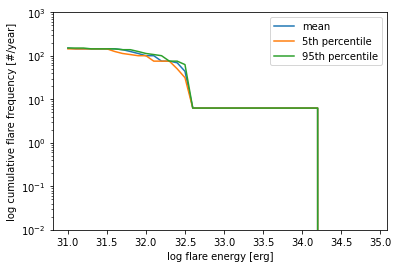

In [231]:
plt.plot(edges[:-1], np.cumsum(hist[::-1])[::-1]*completeness_factor*365/80, label='mean') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges_minus[:-1], np.cumsum(hist_minus[::-1])[::-1]*completeness_factor*365/80, label='5th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges_plus[:-1], np.cumsum(hist_plus[::-1])[::-1]*completeness_factor*365/80, label='95th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.ylabel('log cumulative flare frequency [#/year]')
plt.xlabel('log flare energy [erg]')
plt.legend()
plt.yscale('log')
plt.ylim(1e-2, 1e3)
#plt.ylim([1e-5, 1e0])
#plt.savefig('ffd_30.png', bbox_inches='tight', format='png')
plt.show()

And in counts/year to fit with Ilin et al 2018 Fig 5

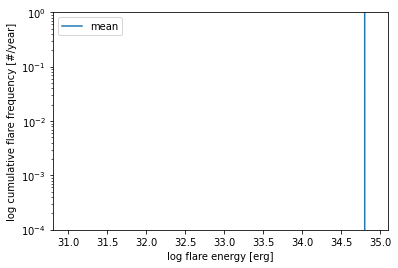

In [4]:
flare_energies = np.array([31.65232945, 31.65625868, 31.66839156, 31.71780824, 31.72024611, 31.73330985,
 31.74423433, 31.77859741, 31.81553114, 31.81636011, 31.82364941, 31.84723029,
 31.86678772, 31.89151046, 31.92291711, 31.95087896, 31.96084788, 31.97869672,
 31.98030125, 32.01374326, 32.0509644,  32.06589309, 32.06602498, 32.08619432,
 32.11617835, 32.13618302, 32.15205672, 32.15444102, 32.1667329,  32.16876577,
 32.18511007, 32.2170479,  32.22424527, 32.22814016, 32.26417377, 32.2796243,
 32.28089802, 32.28819294, 32.30808469, 32.31018691, 32.3175482, 32.3289138,
 32.34529755, 32.35864027, 32.36017821, 32.37431943, 32.38907038, 32.39635535,
 32.41072355, 32.43202149, 32.4820096,  32.4998612,  32.526646,   32.52946413,
 32.54775059, 32.57354957, 32.59595169, 32.6113015,  32.62009853, 32.62273281,
 32.62475126, 32.63103622, 32.64682008, 32.69851471, 32.86278763, 32.87104287,
 33.08295878, 34.87701904])

hist, edges = np.histogram(flare_energies, bins=np.linspace(31.0, 35.0, 41))
###hist_minus, edges_minus = np.histogram(flare_energies_minus, bins=np.linspace(31.0, 35.0, 41))
###hist_plus, edges_plus = np.histogram(flare_energies_plus, bins=np.linspace(31.0, 35.0, 41))

#plt.scatter(edges[:-1], np.log10(hist/80)) # divided by time series length of 80 days
#plt.scatter(edges[:-1], np.log10(np.cumsum(hist[::-1])[::-1]/80)) # cumulative sum; invert order b/c they count from highest bin
#plt.scatter(edges_minus[:-1], np.log10(np.cumsum(hist_minus[::-1])[::-1]/80), marker='v') # cumulative sum; invert order b/c they count from highest bin
#plt.scatter(edges_plus[:-1], np.log10(np.cumsum(hist_plus[::-1])[::-1]/80), marker='^') # cumulative sum; invert order b/c they count from highest bin
#plt.plot(edges[:-1], np.log10(np.cumsum(hist[::-1])[::-1]/80), label='mean') # cumulative sum; invert order b/c they count from highest bin
#plt.plot(edges_minus[:-1], np.log10(np.cumsum(hist_minus[::-1])[::-1]/80), label='5th percentile') # cumulative sum; invert order b/c they count from highest bin
#plt.plot(edges_plus[:-1], np.log10(np.cumsum(hist_plus[::-1])[::-1]/80), label='95th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.plot(edges[:-1], 365*np.cumsum(hist[::-1])[::-1]/80, label='mean') # cumulative sum; invert order b/c they count from highest bin
###plt.plot(edges_minus[:-1], 365*np.cumsum(hist_minus[::-1])[::-1]/80, label='5th percentile') # cumulative sum; invert order b/c they count from highest bin
###plt.plot(edges_plus[:-1], 365*np.cumsum(hist_plus[::-1])[::-1]/80, label='95th percentile') # cumulative sum; invert order b/c they count from highest bin
plt.ylabel('log cumulative flare frequency [#/year]')
plt.xlabel('log flare energy [erg]')
plt.legend()
plt.yscale('log')
plt.ylim(1e-4, 1e0)
#plt.savefig('ffd.png', bbox_inches='tight', format='png')
plt.show()

#### Incorporate errors in stellar properties